## Correlation matrices and eigenvalues across ITR-Delays:

In [137]:
import os
import pandas as pd
import numpy as np
from numpy.linalg import eig, eigvalsh
import matplotlib.pyplot as plt

import eigen_analysis

In [138]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [147]:
def get_per_core_eigvals(cores, dvfs, qps, itr, app, rapl='135', run='0'):
    
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_corr/'
    counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_corr/'
    non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_corr/'

    counters_corr_dict = {}
    non_counters_corr_dict = {}
    all_core_eigvals = {}
    for c in cores:
        counters_corr_file = counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_' + c + '_corr'
        counters_corr_dict[c] = pd.read_csv(counters_corr_file, index_col=0)
        counter_vals, vecs = eig(counters_corr_dict[str(c)])
        for i in range(0, len(counter_vals)):
            counter_vals[i] = counter_vals[i] / counter_vals[0]
        non_counters_corr_file = non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_' + c + '_corr'
        non_counters_corr_dict[c] = pd.read_csv(non_counters_corr_file, index_col=0)
        non_counter_vals, vecs = eig(non_counters_corr_dict[str(c)])
        for i in range(0, len(non_counter_vals)):
            non_counter_vals[i] = non_counter_vals[i] / non_counter_vals[0]
        all_core_eigvals[str(c)] = np.concatenate([np.log(counter_vals[1:4]) , np.log(non_counter_vals[1:4])])

    return all_core_eigvals
        
def get_merged_eigvals(dvfs, qps, itr, app, rapl='135', run='0'):
    
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_merged_corr/'
    merged_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_merged_corr/'
    merged_non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_merged_corr/'
    
    merged_counters_corr_file = merged_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged_corr'
    merged_non_counters_corr_file = merged_non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged_corr'
    merged_eigvals = {}
    
    # all correlation matrices should be precomputed..
    # for now, bail if otherwise
    if (not os.path.exists(merged_counters_corr_file)) or (not os.path.exists(merged_non_counters_corr_file)):
        print('ERROR: Merged log correlation matrix not found or incomplete..')
        print('Aborting..')
        print()
        return merged_eigvals

    merged_counters_corr = pd.read_csv(merged_counters_corr_file, index_col=0)
    merged_non_counters_corr = pd.read_csv(merged_non_counters_corr_file, index_col=0)
    merged_counters_vals, merged_vecs = eig(merged_counters_corr)
    merged_non_counters_vals, merged_vecs = eig(merged_non_counters_corr)

    # scaling by highest eigval (usually the first val is the highest)
    for i in range(0, len(merged_counters_vals)):
        merged_counters_vals[i] = merged_counters_vals[i] / merged_counters_vals[0]    
    for i in range(0, len(merged_non_counters_vals)):
        merged_non_counters_vals[i] = merged_non_counters_vals[i] / merged_non_counters_vals[0]  

    # highest eigval is dropped
    # log of other eigvals is computed and used 
    merged_eigvals = np.concatenate([np.log(merged_counters_vals[1:4]), np.log(merged_non_counters_vals[1:4])])
    return merged_eigvals

def plot_eigvals_across_itrs(eig_dict, dvfs, qps, app):
    plt.figure(figsize=(10,6))

    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    
    for itr in eig_dict.keys():
        vals = eig_dict[itr]
        plt.plot(eig_list, vals, 'p', label=itr) 
    
    plt.xlabel('eigval id')
    plt.ylabel('log( eigval / max_eigval )')
    plt.ylim(-20)
    plt.title(f'{app}: Eigvals of Merged Corr Matrices (DVFS = {dvfs}, QPS = {qps})')
    plt.legend(title = 'ITR-DELAY')
    plt.savefig(app_dir + 'plots/all_itr_eigvals_'+ dvfs + '_' + qps)
    plt.show()


In [148]:
app = 'mcd'
run = '0'
rapl = '135'
dvfs = '0x1300'
qps = '400k'

app_dir = app + '_' + run + '_rapl_' + rapl + '/'
logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
rdtsc_dir = app_dir + qps + '_qps/linux_' + app + '_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'

In [149]:
itrs = list_itrs(rdtsc_dir)
cores = []
cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq
# temporary mcd cores computation (TODO fix)
# cores = [c for c in range(0, 16)]

In [150]:
print(app_dir)
print(logs_dir)
print(rdtsc_dir)
print(f'cores: {cores}')
print(f'itrs: {itrs}')

mcd_0_rapl_135/
mcd_0_rapl_135/400k_qps/linux_mcd_dmesg_0_0x1300_135_400k/
mcd_0_rapl_135/400k_qps/linux_mcd_rdtsc_0_0x1300_135_400k/
cores: ['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']
itrs: ['250', '2', '400', '300', '50', '40', '350', '100', '20', '200', '30', '10']


### Generating plots..

ITR-DELAY: 250
eigvals: [ -0.27740091  -2.87995283 -11.18547613   0.46769095  -1.22479483
  -0.92851782]

ITR-DELAY: 2
eigvals: [ -0.85140423  -1.39251731 -18.50518898   0.1288797   -1.07600913
  -0.61892802]

ITR-DELAY: 400
eigvals: [ -0.9122186   -2.2679649  -10.21532545   0.46615574  -1.22259716
  -0.99124004]

ITR-DELAY: 300
eigvals: [-1.24314811 -2.51434909 -9.35568544  0.463775   -1.24157028 -0.95652328]

ITR-DELAY: 50
eigvals: [ -0.78289872  -1.50356601 -17.06010605   0.38968483  -1.04631702
  -0.66772909]

ITR-DELAY: 40
eigvals: [ -1.2638045   -2.41008634 -17.71592856   0.35334148  -1.03326456
  -0.62796348]

ITR-DELAY: 350
eigvals: [-1.09301185 -2.66483401 -8.69961582  0.46481392 -1.23463061 -0.98126579]

ITR-DELAY: 100
eigvals: [ -0.75691227  -1.61176334 -15.59852881   0.41792416  -1.08850992
  -0.74939682]

ITR-DELAY: 20
eigvals: [ -0.83472525  -1.33877955 -17.57229407   0.13333763  -1.06067296
  -0.52121488]

ITR-DELAY: 200
eigvals: [ -0.91315484  -1.93642946 -12.03835855  

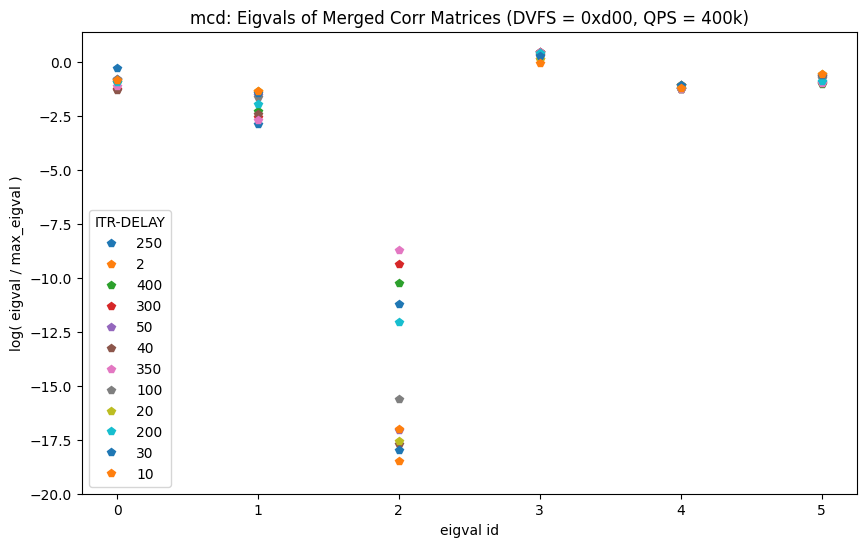

ITR-DELAY: 250
eigvals: [-1.01552817 -2.23730843 -6.13292033  0.46140894 -1.19819972 -0.90585936]

ITR-DELAY: 2
eigvals: [ -0.83523699  -1.45925623 -16.28325825   0.11321507  -1.07973377
  -0.6220051 ]

ITR-DELAY: 400
eigvals: [-1.10070999 -2.81520247 -5.89686834  0.46591145 -1.21362795 -0.98273613]

ITR-DELAY: 300
eigvals: [-0.9915058  -2.37182859 -5.70227666  0.46855814 -1.21969978 -0.95182464]

ITR-DELAY: 50
eigvals: [ -0.74997557  -1.45240387 -17.8083514    0.38804667  -1.04393693
  -0.6730272 ]

ITR-DELAY: 40
eigvals: [ -0.77153428  -1.36748312 -15.54943349   0.3552416   -1.03029069
  -0.64906305]

ITR-DELAY: 350
eigvals: [-0.94037243 -2.23985697 -7.09418155  0.46705006 -1.19773747 -0.94659167]

ITR-DELAY: 100
eigvals: [ -0.83901245  -1.52172906 -13.11929715   0.42499448  -1.08384335
  -0.77058316]

ITR-DELAY: 20
eigvals: [ -0.80685466  -1.33946083 -14.41442563   0.13484068  -1.04758801
  -0.53758722]

ITR-DELAY: 200
eigvals: [-1.08066431 -2.00096828 -7.24971219  0.45022679 -1.166

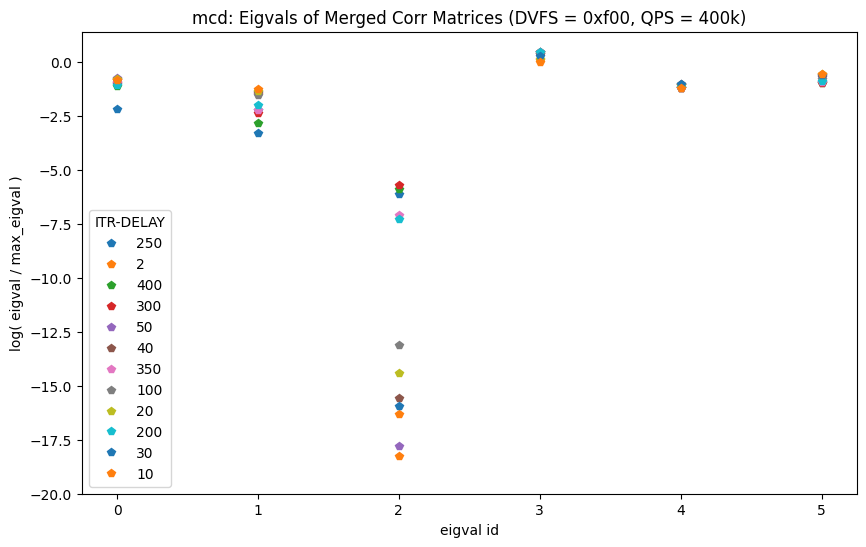

ITR-DELAY: 250
eigvals: [-1.59193169 -2.56005013 -6.17803258  0.45871512 -1.18934524 -0.90141903]

ITR-DELAY: 2
eigvals: [ -0.83209464  -1.48249384 -13.95273258   0.10057223  -1.08131383
  -0.62380166]

ITR-DELAY: 400
eigvals: [-1.11018904 -2.72176876 -5.12936661  0.44507567 -1.21646579 -1.00112931]

ITR-DELAY: 300
eigvals: [-0.99535904 -2.62216818 -4.55562224  0.46729929 -1.21258357 -0.93062067]

ITR-DELAY: 50
eigvals: [ -2.09997864  -3.93802997 -16.83936406   0.39006417  -1.03515433
  -0.69044966]

ITR-DELAY: 40
eigvals: [ -0.75224685  -1.36980292 -13.66333021   0.35472339  -1.02390545
  -0.65970993]

ITR-DELAY: 350
eigvals: [-1.0877832  -2.40101927 -5.3710394   0.46341436 -1.21056392 -0.97116491]

ITR-DELAY: 100
eigvals: [-1.22531182 -1.84936498 -9.37397062  0.42558768 -1.07047058 -0.76866983]

ITR-DELAY: 20
eigvals: [ -0.77206935  -1.30035595 -17.6928493    0.1315284   -1.04926661
  -0.55888794]

ITR-DELAY: 200
eigvals: [-0.7299447  -4.23053945 -8.34727027  0.45010223 -1.15648978 -

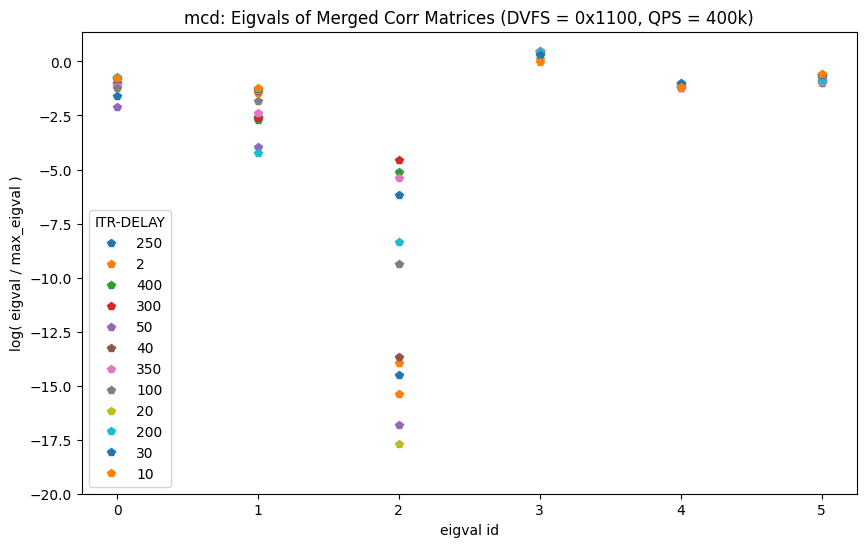

ITR-DELAY: 250
eigvals: [-1.06822979 -2.37891297 -4.49289215  0.46001446 -1.18235233 -0.89221572]

ITR-DELAY: 2
eigvals: [ -0.76188811  -1.46615526 -17.96987375   0.09090071  -1.08306277
  -0.62226698]

ITR-DELAY: 400
eigvals: [-1.11947569 -2.51804194 -4.2305401   0.44940386 -1.21286811 -1.0227624 ]

ITR-DELAY: 300
eigvals: [-1.04929072 -2.45425064 -3.75021881  0.46766371 -1.21611314 -0.93689384]

ITR-DELAY: 50
eigvals: [ -1.61714763  -0.98907649 -13.01628359   0.39078217  -1.03436849
  -0.70032675]

ITR-DELAY: 40
eigvals: [-0.95906823 -1.53082282 -7.54681089  0.35213808 -1.01668363 -0.664275  ]

ITR-DELAY: 350
eigvals: [-1.07205547 -2.64723494 -4.42810968  0.46576405 -1.18933131 -0.94385923]

ITR-DELAY: 100
eigvals: [-0.19020285 -2.17122604 -7.48442142  0.42967714 -1.07470517 -0.77993503]

ITR-DELAY: 20
eigvals: [ -0.78428275  -1.27353031 -14.09910842   0.12942871  -1.04222002
  -0.56830304]

ITR-DELAY: 200
eigvals: [-1.29556174 -2.19204743 -4.83622904  0.45342008 -1.14706364 -0.86194

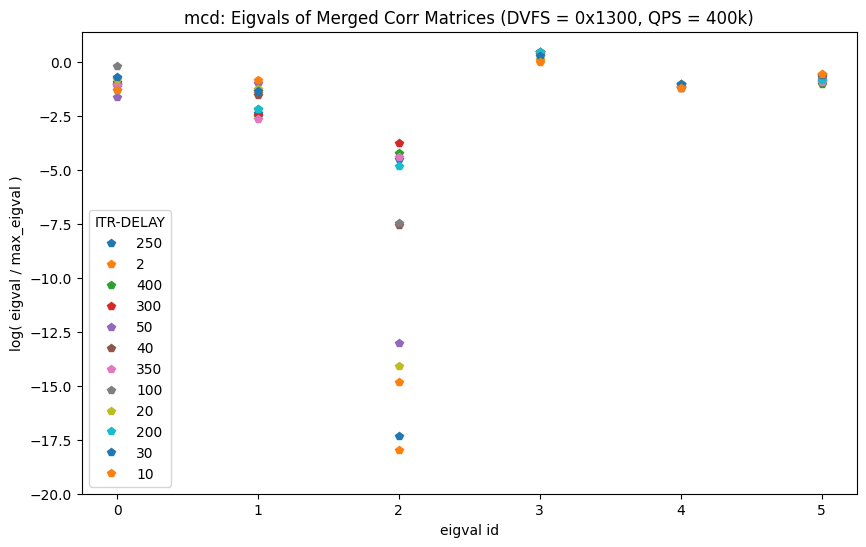

ITR-DELAY: 250
eigvals: [-1.09973061 -2.35698598 -3.99530057  0.45216434 -1.16040496 -0.85571263]

ITR-DELAY: 2
eigvals: [ -0.88556155  -1.49151574 -15.25971038   0.08268266  -1.09063287
  -0.63085109]

ITR-DELAY: 400
eigvals: [-1.03926676 -2.38995977 -4.195056    0.45618785 -1.17817867 -0.98128902]

ITR-DELAY: 300
eigvals: [-1.47817433 -3.37758979 -4.97247973  0.46358261 -1.18866324 -0.91681398]

ITR-DELAY: 50
eigvals: [ -2.11825094  -1.93330364 -12.92833342   0.39443499  -1.03253382
  -0.71798212]

ITR-DELAY: 40
eigvals: [-1.32796054 -1.9197469  -8.97072114  0.34864948 -1.01640637 -0.6677712 ]

ITR-DELAY: 350
eigvals: [-1.07126391 -2.38231815 -4.0250192   0.44150036 -1.21683197 -1.01234315]

ITR-DELAY: 100
eigvals: [-1.2015197  -1.92183323 -6.11464697  0.42901621 -1.0651342  -0.77837236]

ITR-DELAY: 20
eigvals: [ -0.86364938  -1.32161759 -14.25892078   0.12853067  -1.04099988
  -0.58693796]

ITR-DELAY: 200
eigvals: [-1.08446535 -2.08101305 -3.7900389   0.45240137 -1.15313    -0.86887

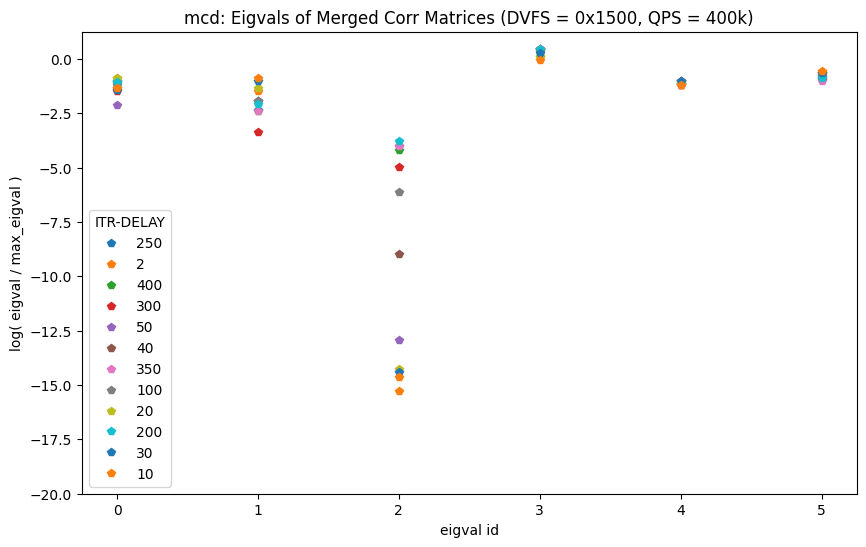

ITR-DELAY: 250
eigvals: [-1.11180651 -2.27538413 -3.55895805  0.45201457 -1.15446283 -0.86374784]

ITR-DELAY: 2
eigvals: [ -1.59018468  -0.96842549 -14.02523043   0.07787469  -1.08945329
  -0.62628606]

ITR-DELAY: 400
eigvals: [-0.96279721 -2.39906963 -3.44157327  0.46116973 -1.17793119 -0.95088299]

ITR-DELAY: 300
eigvals: [-0.93928503 -2.28486256 -3.70299993  0.4594631  -1.16790627 -0.90737598]

ITR-DELAY: 50
eigvals: [ -1.74490905  -1.27390688 -11.64371902   0.39551482  -1.03147577
  -0.72172334]

ITR-DELAY: 40
eigvals: [ -1.5270938   -1.0978704  -12.95466962   0.34926747  -1.01358558
  -0.68396521]

ITR-DELAY: 350
eigvals: [-1.07141127 -2.24848064 -3.4077177   0.45377772 -1.19279236 -0.97301101]

ITR-DELAY: 100
eigvals: [-1.39478385 -1.97278271 -5.11948511  0.42774931 -1.06803907 -0.77587351]

ITR-DELAY: 20
eigvals: [ -3.10849648  -4.19443096 -15.35026399   0.12890796  -1.03344842
  -0.59655095]

ITR-DELAY: 200
eigvals: [-1.35504479 -2.15510128 -3.28477874  0.44733184 -1.14010646 -

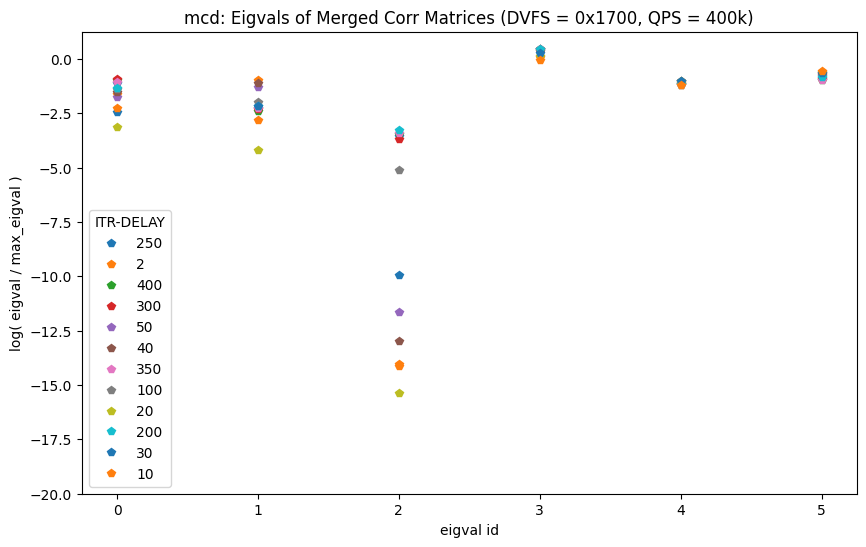

ITR-DELAY: 250
eigvals: [-1.22864848 -2.28039492 -3.16313982  0.45164994 -1.1545055  -0.85548411]

ITR-DELAY: 2
eigvals: [ -1.66877463  -1.0970571  -17.37238911   0.07277857  -1.09072812
  -0.62736233]

ITR-DELAY: 400
eigvals: [-1.0241456  -2.41181159 -3.47299219  0.45105361 -1.17686587 -0.98228368]

ITR-DELAY: 300
eigvals: [-0.97037217 -2.2245069  -3.37172591  0.4559384  -1.16601632 -0.91117374]

ITR-DELAY: 50
eigvals: [ -1.71741366  -1.3321089  -10.20195811   0.39224615  -1.02158062
  -0.70938494]

ITR-DELAY: 40
eigvals: [ -1.55842573  -1.17772593 -12.5429772    0.34985622  -1.00989526
  -0.68628953]

ITR-DELAY: 350
eigvals: [-1.70519213 -2.92911295 -4.07730268  0.45890711 -1.1638977  -0.9169214 ]

ITR-DELAY: 100
eigvals: [-1.45231737 -2.06196259 -4.34165511  0.42956465 -1.06948608 -0.7818236 ]

ITR-DELAY: 20
eigvals: [ -2.7158853   -3.18928339 -13.54708731   0.13483039  -1.03410852
  -0.61313191]

ITR-DELAY: 200
eigvals: [-1.35491401 -4.90800313 -6.60841725  0.44368218 -1.12633261 -

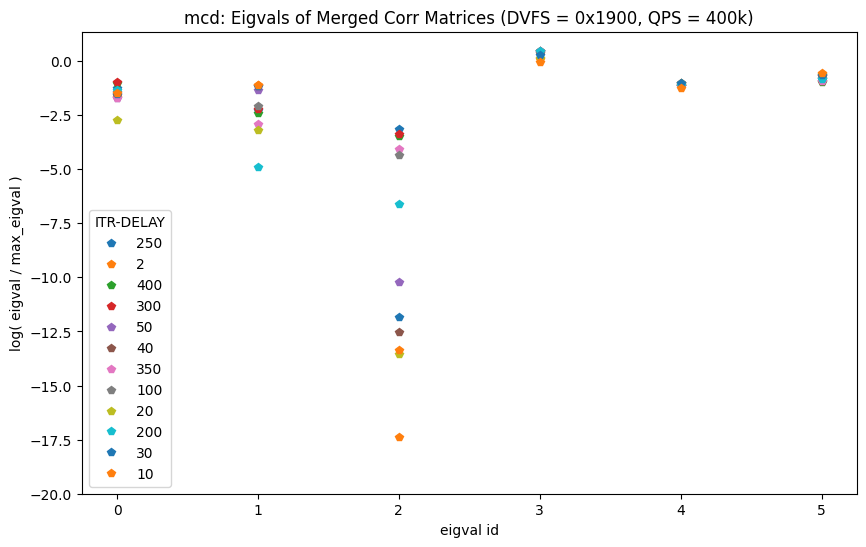

ITR-DELAY: 250
eigvals: [-2.4431771  -3.90191681 -4.73028547  0.45476776 -1.15891616 -0.8663899 ]

ITR-DELAY: 2
eigvals: [ -3.52381285  -4.24308983 -11.45816907   0.06855885  -1.09198236
  -0.62530271]

ITR-DELAY: 400
eigvals: [-0.97029304 -2.34144438 -3.12537341  0.46144378 -1.16671462 -0.97045075]

ITR-DELAY: 300
eigvals: [-0.98591482 -2.09656011 -2.8444925   0.46128283 -1.16149556 -0.90659349]

ITR-DELAY: 50
eigvals: [-1.73030052 -1.26726167 -9.02067695  0.39649597 -1.02519932 -0.72119404]

ITR-DELAY: 40
eigvals: [ -1.5655318   -1.16056851 -12.63682125   0.34981886  -1.01122642
  -0.69584155]

ITR-DELAY: 350
eigvals: [-2.01954873 -4.16825865 -5.12406546  0.46381665 -1.18424791 -0.96500542]

ITR-DELAY: 100
eigvals: [-1.43761842 -2.0397374  -3.99717597  0.42967439 -1.06899692 -0.78154134]

ITR-DELAY: 20
eigvals: [ -3.28745153  -3.63266894 -10.36842888   0.14014731  -1.02678774
  -0.61000054]

ITR-DELAY: 200
eigvals: [-2.72422406 -1.65206969 -1.38011484  0.44689371 -1.13456019 -0.83681

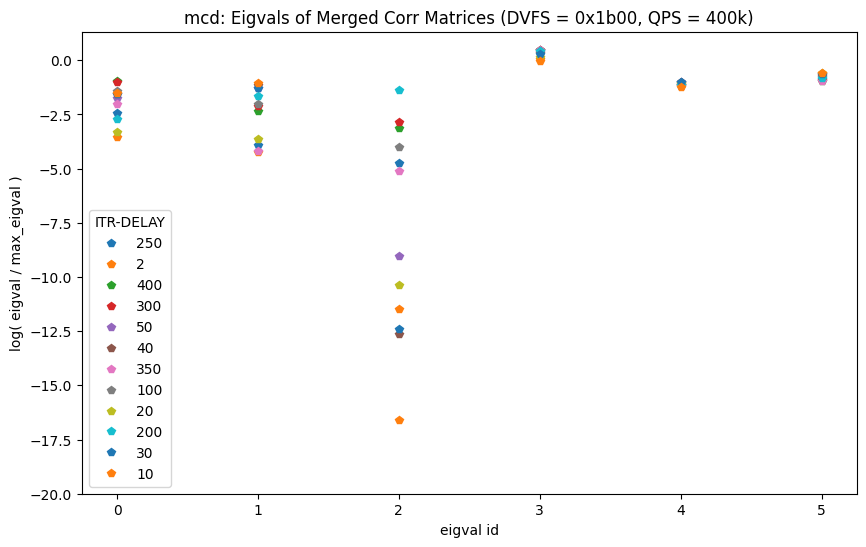

ITR-DELAY: 250
eigvals: [-2.75362249 -1.07884719 -1.48088661  0.45540869 -1.15103365 -0.86995967]

ITR-DELAY: 2
eigvals: [ -1.2666165   -1.77726027 -10.58865227   0.06261057  -1.09773622
  -0.62917778]

ITR-DELAY: 400
eigvals: [-1.03155048 -2.58141658 -3.39208685  0.45980789 -1.15135215 -0.91683493]

ITR-DELAY: 300
eigvals: [-1.15509383 -2.61680369 -1.70356809  0.46430058 -1.17653794 -0.91576194]

ITR-DELAY: 50
eigvals: [-3.33517821 -3.87798869 -9.69462991  0.39995085 -1.02427439 -0.73291073]

ITR-DELAY: 40
eigvals: [ -1.6285709   -1.21027902 -11.32980226   0.35129189  -1.0065981
  -0.70121852]

ITR-DELAY: 350
eigvals: [-1.07743345 -2.08483832 -2.96401139  0.46003101 -1.15286994 -0.91044507]

ITR-DELAY: 100
eigvals: [-2.57838911 -4.10708739 -5.84058926  0.42776803 -1.06225437 -0.77728483]

ITR-DELAY: 20
eigvals: [ -1.48023906  -1.20832704 -12.67541008   0.14224082  -1.0262752
  -0.61654428]

ITR-DELAY: 200
eigvals: [-1.4343152  -2.18221356 -3.20378664  0.44681449 -1.12689494 -0.8391707

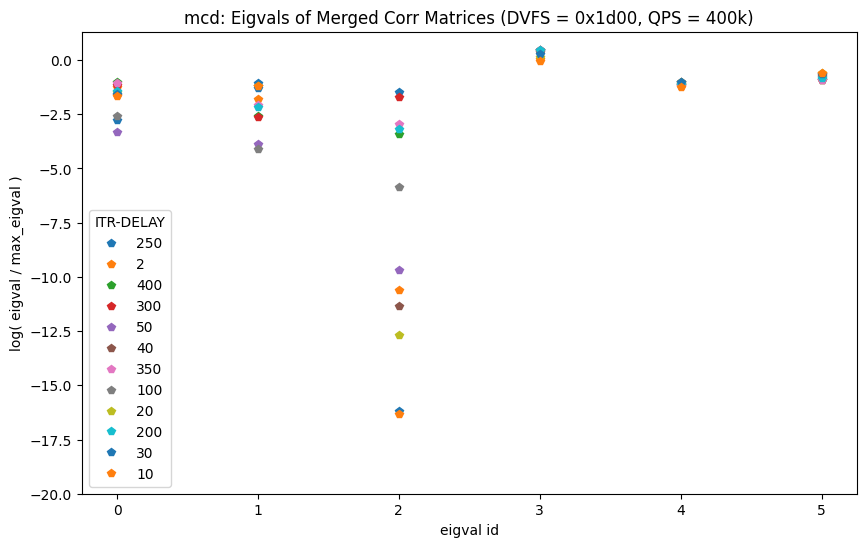

In [151]:
for dvfs in ['0xd00', '0xf00', '0x1100', '0x1300', '0x1500', '0x1700', '0x1900', '0x1b00', '0x1d00']:
#for dvfs in ['0x1d00']:
    eig_dict = {}
    for itr in itrs:
        if (itr == '10') and (dvfs == '0xd00') and (qps == '200k'):
            continue
        print(f'ITR-DELAY: {itr}')
        eigvals = get_merged_eigvals(dvfs, qps, itr, app, rapl, run)
        if len(eigvals) != 0:
            print(f'eigvals: {eigvals}')
            eig_dict[itr] = eigvals
            print()
    if len(eig_dict) != 0:
        plot_eigvals_across_itrs(eig_dict, dvfs, qps, app)

## Older code... discard later

In [2]:
def get_latencies(out_fname):
    with open(out_fname, 'r') as f:
        lines = f.readlines()
    header = lines[0].rstrip('\n').split()
    read_lat = lines[1].rstrip('\n').split()
    lat = {'read': dict(zip(header[1:], [float(y) for y in read_lat[1:]]))}

    return lat['read']

In [3]:
def get_joules(df):
    joules_sum = df['joules_diff'].sum()
    joules = {'joules_sum': joules_sum}
    
    return joules

### Correlation Matrices: reflect dependencies/relationships between different columns of time-series data

In [25]:
corr_dvfs_counter_list = {}
eig_dvfs_counters_list = {}
corr_dvfs_non_counter_list = {}
eig_dvfs_non_counters_list = {}
joules_dvfs_list = {}

#for dvfs in ['0xd00', '0xf00', '0x1100', '0x1300', '0x1500', '0x1700', '0x1900', '0x1b00', '0x1d00']:
for dvfs in [dvfs]:
    corr_qps_counter_list = {}
    corr_qps_non_counter_list = {}
    joules_qps_list = {}
    eig_qps_counters_list = {}
    eig_qps_non_counters_list = {}

    
#    for qps in ['200k', '400k', '600k']:
    for qps in [qps]:
        merged_dir = app_dir + qps + '_merged/'
        corr_dir = app_dir + qps + '_merged_corr/'
        counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_merged_corr/'
        !mkdir -p $counters_corr_dir
        non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_merged_corr/'
        !mkdir -p $non_counters_corr_dir

        corr_itr_counters_list = {}
        corr_itr_non_counters_list = {}
        
        #eig_itr_counters_list = {}
        #eig_itr_non_counters_list = {}
        
        eig_itr_list = {}
        joules_itr_list = {}
            
        for itr in itrs:
            print()
            print(f'ITR-DELAY : {itr}')
            
            counters_corr_file = counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged_corr'
            non_counters_corr_file = non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged_corr'

            # all correlation matrices should be precomputed..
            # for now, bail if otherwise
            if os.path.exists(counters_corr_file):
                counters_corr = pd.read_csv(counters_corr_file, index_col=0)
                if os.path.exists(non_counters_corr_file):
                    non_counters_corr = pd.read_csv(non_counters_corr_file, index_col=0)
            else:
                print('Merged log correlation matrix not found.')
                print('Aborting..')
                continue

            
            corr_itr_counters_list[itr] = counters_corr
            corr_itr_non_counters_list[itr] = non_counters_corr
            
            #vals_counters_dict = {}
            #vals_non_counters_dict = {}
            
            eigvals = {}
            vals_counters, vecs_counters = eig(counters_corr)
            vals_non_counters, vecs_non_counters = eig(non_counters_corr)
            i = 0
            for val in vals_counters:
                if val <= 0:
                    print(f'EIGENVAL <= 0 ({val})')
                eigvals['eig_' + str(i)] = val
                i += 1
            for val in vals_non_counters:
                if val <= 0:
                    print(f'EIGENVAL <= 0 ({val})')
                eigvals['eig_' + str(i)] = val
                i += 1
                
            #eig_itr_counters_list[itr] = vals_counters_dict    
            #eig_itr_non_counters_list[itr] = vals_non_counters_dict
            
            eig_itr_list[itr] = eigvals

        print()
        print(f'counters_corr_list: {corr_itr_counters_list}')
        print(f'non_counters_corr_list: {corr_itr_non_counters_list}')
        print()
        print(f'eig_itr_list: {eig_itr_list}')
        #print(f'counters_eig_list: {eig_itr_counters_list}')
        #print(f'non_counters_eig_list: {eig_itr_non_counters_list}')
        break
    break

# #        all_itr_counter_dir = merged_logs_dir + qps + '_' + dvfs + '_counters_merged/archive/'
# #        all_itr_non_counter_dir = merged_logs_dir + qps + '_' + dvfs + '_non_counters_merged/archive/'

# #        print('Parsing counter metrics in ' + all_itr_counter_dir)
# #        for file in os.listdir(all_itr_counter_dir):
# #            
# #            !gunzip -v $all_itr_counter_dir$file
# #            
# #            if (os.path.isdir(all_itr_non_counter_dir + file) or (file == '.gitignore')):
# #                continue
# #            itr = file.split('_')[2]
# #            df = pd.read_csv(all_itr_counter_dir + file, sep = ',')
# #            joules = get_joules(df.copy())
# #            joules_itr_list[itr] = joules
# #            print('ITR_DELAY: ', itr, joules)
# #            df = df.drop([df.columns[0], 'joules_diff', 'timestamp'], axis=1)
#             df_corr = df.corr()
#             corr_itr_counter_list[itr] = df_corr
            
#             vals_counters_dict = {}
#             vals_counters, vecs_counter = eig(df_corr)
#             i = 0
#             for val in vals_counters:
#                 if val <= 0:
#                     print('EIGENVAL <= 0')
#                 vals_counters_dict['eig_' + str(i)] = val
#                 i += 1
#             eig_itr_counters_list[itr] = vals_counters_dict

#             !gzip -v9 $all_itr_counter_dir$file
        
#         print('Parsing non-counter metrics in ' + all_itr_non_counter_dir)
#         for file in os.listdir(all_itr_non_counter_dir):
            
#             !gunzip -v $all_itr_non_counter_dir$file
            
#             if (os.path.isdir(all_itr_non_counter_dir + file) or (file == '.gitignore')):
#                 continue
#             itr = file.split('_')[2]
#             print('ITR_DELAY: ', itr)
#             df = pd.read_csv(all_itr_non_counter_dir + file, sep= ',')
#             df_corr = df.drop([df.columns[0], 'timestamp'], axis = 1).corr()
#             corr_itr_non_counter_list[itr] = df_corr
            
#             i = 4
#             vals_non_counters_dict = {}
#             vals_non_counters, vecs_non_counter = eig(df_corr)
#             for val in vals_non_counters:
#                 if val <= 0:
#                     print('EIGENVAL <= 0')
#                 vals_non_counters_dict['eig_' + str(i)] = val
#                 i += 1
#             eig_itr_non_counters_list[itr] = vals_non_counters_dict

#             !gzip -v9 $all_itr_non_counter_dir$file
            
#         corr_qps_counter_list[qps] = corr_itr_counter_list
#         corr_qps_non_counter_list[qps] = corr_itr_non_counter_list
#         joules_qps_list[qps] = joules_itr_list
#         eig_qps_counters_list[qps] = eig_itr_counters_list
#         eig_qps_non_counters_list[qps] = eig_itr_non_counters_list
        
#     corr_dvfs_counter_list[dvfs] = corr_qps_counter_list
#     corr_dvfs_non_counter_list[dvfs] = corr_qps_non_counter_list
#     joules_dvfs_list[dvfs] = joules_qps_list
#     eig_dvfs_counters_list[dvfs] = eig_qps_counters_list
#     eig_dvfs_non_counters_list[dvfs] = eig_qps_non_counters_list


ITR-DELAY : 300
Merged log correlation matrix not found.
Aborting..

ITR-DELAY : 20
Merged log correlation matrix not found.
Aborting..

ITR-DELAY : 30
Merged log correlation matrix not found.
Aborting..

ITR-DELAY : 10
Merged log correlation matrix not found.
Aborting..

ITR-DELAY : 50
Merged log correlation matrix not found.
Aborting..

ITR-DELAY : 100

ITR-DELAY : 40
Merged log correlation matrix not found.
Aborting..

ITR-DELAY : 200

counters_corr_list: {'100':                    instructions_diff  cycles_diff  ref_cycles_diff  \
instructions_diff           1.000000     0.961063         0.959866   
cycles_diff                 0.961063     1.000000         0.999480   
ref_cycles_diff             0.959866     0.999480         1.000000   
llc_miss_diff               0.928218     0.950676         0.949679   

                   llc_miss_diff  
instructions_diff       0.928218  
cycles_diff             0.950676  
ref_cycles_diff         0.949679  
llc_miss_diff           1.000000  , '

In [32]:
# for dvfs in ['0x1100']:
#     corr_qps_counter_list = {}
#     corr_qps_non_counter_list = {}
#     joules_qps_list = {}
#     eig_qps_counters_list = {}
#     eig_qps_non_counters_list = {}
    
#     for qps in ['200k']:
#         merged_logs_dir = qps + '_merged/'
        
#         corr_itr_counter_list = {}
#         corr_itr_non_counter_list = {}
#         joules_itr_list = {}
#         eig_itr_counters_list = {}
#         eig_itr_non_counters_list = {}
        
#         all_itr_counter_dir = merged_logs_dir + qps + '_' + dvfs + '_counters_merged/archive/'
#         all_itr_non_counter_dir = merged_logs_dir + qps + '_' + dvfs + '_non_counters_merged/archive/'

#         print('Compressing counter metrics in ' + all_itr_counter_dir)
#         for file in os.listdir(all_itr_counter_dir):
#             !gzip -v9 $all_itr_counter_dir$file
#         print('Compressing non_counter metrics in ' + all_itr_non_counter_dir)
#         for file in os.listdir(all_itr_non_counter_dir):
#             !gzip -v9 $all_itr_non_counter_dir$file


In [24]:
# checking corr matrix
corr_dvfs_counter_list['0x1100']['600k']['300']

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.918864,0.921257,0.606254
cycles_diff,0.918864,1.000000,0.997620,0.777789
ref_cycles_diff,0.921257,0.997620,1.000000,0.771369
llc_miss_diff,0.606254,0.777789,0.771369,1.000000


In [26]:
# checking corr matrix
corr_dvfs_non_counter_list['0x1100']['600k']['100']

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.688024,0.016659,0.024947
rx_desc,0.688024,1.000000,0.037897,0.047329
tx_bytes,0.016659,0.037897,1.000000,0.540762
tx_desc,0.024947,0.047329,0.540762,1.000000


In [27]:
# checking joules sum values
joules_dvfs_list['0x1100']['600k']

{'40': {'joules_sum': 51701.443894},
 '100': {'joules_sum': 50282.50123900005},
 '350': {'joules_sum': 46968.89126399995},
 '300': {'joules_sum': 47547.76753900007},
 '30': {'joules_sum': 52341.02242799991},
 '200': {'joules_sum': 48940.19977700003},
 '50': {'joules_sum': 51350.231513999985},
 '250': {'joules_sum': 48044.051461000054},
 '20': {'joules_sum': 52348.05920499994},
 '10': {'joules_sum': 52666.53941200003},
 '2': {'joules_sum': 52679.300368},
 '400': {'joules_sum': 47181.397756999955}}

In [28]:
eig_dvfs_counters_list['0x1100']['600k']

{'40': {'eig_0': 3.317612688915927,
  'eig_1': 0.4826246710068562,
  'eig_2': 0.19976180618786352,
  'eig_3': 8.338893551504741e-07},
 '100': {'eig_0': 3.4112449934277405,
  'eig_1': 0.4569844772045554,
  'eig_2': 0.13176856430803646,
  'eig_3': 1.9650596687614825e-06},
 '350': {'eig_0': 3.566010655662864,
  'eig_1': 0.3709717619970818,
  'eig_2': 0.06050016925881138,
  'eig_3': 0.0025174130812429638},
 '300': {'eig_0': 3.511624484626556,
  'eig_1': 0.41899301663287014,
  'eig_2': 0.0670564426499798,
  'eig_3': 0.002326056090592861},
 '30': {'eig_0': 3.9824994704001218,
  'eig_1': 0.013202361513610598,
  'eig_2': 0.004298087757765275,
  'eig_3': 8.032849971263602e-08},
 '200': {'eig_0': 3.4767208085024413,
  'eig_1': 0.42845679059735436,
  'eig_2': 0.09344702080250315,
  'eig_3': 0.0013753800977002332},
 '50': {'eig_0': 3.3491699641217973,
  'eig_1': 0.47724917044385523,
  'eig_2': 0.17358081229992733,
  'eig_3': 5.313441824299114e-08},
 '250': {'eig_0': 3.4906908477401313,
  'eig_1': 

In [29]:
eig_dvfs_non_counters_list['0x1100']['600k']

{'250': {'eig_4': 1.756652381428518,
  'eig_5': 1.5849532707932632,
  'eig_6': 0.2834096776246905,
  'eig_7': 0.3749846701535269},
 '350': {'eig_4': 1.782947665246136,
  'eig_5': 1.5807230863547777,
  'eig_6': 0.28493480541111404,
  'eig_7': 0.35139444298796807},
 '30': {'eig_4': 1.6691109451529667,
  'eig_5': 1.4387841788180953,
  'eig_6': 0.34885851323957506,
  'eig_7': 0.5432463627893642},
 '20': {'eig_4': 1.747176312965617,
  'eig_5': 1.3087857475989977,
  'eig_6': 0.3517141618134973,
  'eig_7': 0.59232377762189},
 '400': {'eig_4': 1.8000064912552936,
  'eig_5': 1.57526641228173,
  'eig_6': 0.28415550107284426,
  'eig_7': 0.34057159539013265},
 '100': {'eig_4': 1.7116653529408878,
  'eig_5': 1.5175727556892462,
  'eig_6': 0.31158545626323075,
  'eig_7': 0.45917643510663597},
 '300': {'eig_4': 1.7665839424729382,
  'eig_5': 1.5879219358651304,
  'eig_6': 0.28356640782381115,
  'eig_7': 0.36192771383812045},
 '2': {'eig_4': 1.9545816308844188,
  'eig_5': 1.1566428440500645,
  'eig_6'

### Latency Measurements:

In [34]:
lat_dvfs_list = {}
for dvfs in ['0xd00', '0xf00', '0x1100', '0x1300', '0x1500', '0x1700', '0x1900', '0x1b00', '0x1d00']:
    lat_qps_list = {}
    for qps in ['200k', '400k', '600k']:
        lat_itr_list = {}
        lat_dir = qps + '_qps/linux_mcd_out_0_' + dvfs + '_135_' + qps + '/'

        for itr in corr_dvfs_counter_list[dvfs][qps].keys():
            lat_file = lat_dir + 'linux.mcd.out.0_' + str(itr) + '_' + dvfs + '_135_' + qps[:-1] + '000'
            latencies = get_latencies(lat_file)
            lat_itr_list[itr] = latencies
        lat_qps_list[qps] = lat_itr_list
    lat_dvfs_list[dvfs] = lat_qps_list

In [35]:
lat_dvfs_list['0x1900']['200k']['100']

{'avg': 101.6,
 'std': 30.9,
 'min': 37.4,
 '5th': 53.2,
 '10th': 59.2,
 '50th': 101.9,
 '90th': 142.1,
 '95th': 151.6,
 '99th': 170.1}

### Putting it all together:

In [36]:
lat_columns = []
for itr in [list(lat_dvfs_list['0x1100']['200k'].keys())[0]]:
    lat_columns = list(lat_dvfs_list['0x1100']['200k'][itr].keys())
lat_columns

['avg', 'std', 'min', '5th', '10th', '50th', '90th', '95th', '99th']

In [37]:
eig_counters_columns = []
for itr in [list(eig_dvfs_counters_list['0x1100']['200k'].keys())[0]]:
    eig_counters_columns = list(eig_dvfs_counters_list['0x1100']['200k'][itr].keys())
eig_non_counters_columns = []
for itr in [list(eig_dvfs_non_counters_list['0x1100']['200k'].keys())[0]]:
    eig_non_counters_columns += list(eig_dvfs_non_counters_list['0x1100']['200k'][itr].keys())
eig_columns = eig_counters_columns + eig_non_counters_columns
eig_columns

['eig_0', 'eig_1', 'eig_2', 'eig_3', 'eig_4', 'eig_5', 'eig_6', 'eig_7']

In [38]:
all_cols = lat_columns + eig_columns + ['joules_sum']
all_cols.append('desc')
print(all_cols)

['avg', 'std', 'min', '5th', '10th', '50th', '90th', '95th', '99th', 'eig_0', 'eig_1', 'eig_2', 'eig_3', 'eig_4', 'eig_5', 'eig_6', 'eig_7', 'joules_sum', 'desc']


In [39]:
eig_dvfs_non_counters_list['0x1300']['200k']['10']

{'eig_4': 2.294147382104687,
 'eig_5': 0.9014327690853716,
 'eig_6': 0.5649305538527354,
 'eig_7': 0.23948929495720625}

In [42]:
eig_lat_joules_df = pd.DataFrame(columns=all_cols)
for dvfs in ['0xd00', '0xf00', '0x1100', '0x1300', '0x1500', '0x1700', '0x1800', '0x1900', '0x1a00', '0x1b00', '0x1c00', '0x1d00']:
    for qps in ['50k', '100k']:
        for itr in corr_dvfs_counter_list[dvfs][qps].keys():
            desc = '0' + '_' + itr + '_' + dvfs + '_' + '135' + '_' + qps
            new_row = {}
            for p in lat_columns:
                new_row[p] = lat_dvfs_list[dvfs][qps][itr][p]
            for e in eig_counters_columns:
                new_row[e] = eig_dvfs_counters_list[dvfs][qps][itr][e]
            for e in eig_non_counters_columns:
                new_row[e] = eig_dvfs_non_counters_list[dvfs][qps][itr][e]
            new_row['joules_sum'] = joules_dvfs_list[dvfs][qps][itr]['joules_sum']
            new_row['desc'] = desc
            eig_lat_joules_df = eig_lat_joules_df._append(new_row, ignore_index = True)

In [43]:
eig_lat_joules_df

,avg,std,min,5th,10th,50th,90th,95th,99th,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,joules_sum,desc
0,81.8,17.0,45.3,58.8,61.6,79.8,104.5,112.7,130.8,3.492777,0.199347,0.307877,1.926252e-08,1.874681,1.206367,0.388455,0.530496,35745.289533,0_40_0xd00_135_200k
1,179.3,57.8,45.3,86.6,100.6,180.9,256.3,270.5,297.3,3.608221,0.258202,0.133167,4.096448e-04,1.670789,1.540596,0.354743,0.433872,34341.416562,0_200_0xd00_135_200k
2,74.0,14.6,49.8,57.1,59.7,71.1,92.8,102.1,124.4,3.524457,0.190145,0.285398,2.713862e-08,2.161959,0.972311,0.308426,0.557303,35966.114230,0_20_0xd00_135_200k
3,292.5,113.5,49.8,111.7,135.7,294.9,442.9,471.3,515.1,3.593040,0.285410,0.121201,3.490791e-04,1.696883,1.574022,0.327540,0.401555,33724.280904,0_400_0xd00_135_200k
4,71.3,17.4,41.1,55.1,56.2,66.2,93.0,104.9,134.4,3.599618,0.245315,0.155067,8.947988e-08,2.069599,1.061065,0.347774,0.521561,36046.761964,0_2_0xd00_135_200k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,57.5,17.2,34.0,42.0,43.3,53.5,75.6,86.5,123.3,3.956992,0.026499,0.016508,1.003158e-06,2.014633,1.106153,0.334646,0.544568,92513.073726,0_2_0x1d00_135_600k
320,206.0,71.4,41.1,92.7,110.4,205.8,300.6,322.0,358.2,3.423851,0.406464,0.125272,4.441266e-02,1.707851,1.596945,0.296460,0.398744,74429.830394,0_250_0x1d00_135_600k
321,71.1,14.7,34.0,49.2,52.7,71.0,88.0,94.9,110.9,3.879166,0.084843,0.035979,1.202505e-05,1.657982,1.498096,0.350948,0.492973,86921.377698,0_40_0x1d00_135_600k
322,106.0,29.2,37.4,60.0,66.7,106.3,145.2,152.8,168.8,3.513134,0.362429,0.120706,3.730351e-03,1.677405,1.543122,0.327947,0.451526,81377.862032,0_100_0x1d00_135_600k


In [47]:
outdir = app_dir + 'eig_lat_joules_dfs/'
eig_lat_joules_df.to_csv(outdir + 'all_dvfs_qps_itr')

In [48]:
df = pd.read_csv(outdir + 'all_dvfs_qps_itr', index_col=0)

In [49]:
df

,avg,std,min,5th,10th,50th,90th,95th,99th,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,joules_sum,desc
0,81.8,17.0,45.3,58.8,61.6,79.8,104.5,112.7,130.8,3.492777,0.199347,0.307877,1.926252e-08,1.874681,1.206367,0.388455,0.530496,35745.289533,0_40_0xd00_135_200k
1,179.3,57.8,45.3,86.6,100.6,180.9,256.3,270.5,297.3,3.608221,0.258202,0.133167,4.096448e-04,1.670789,1.540596,0.354743,0.433872,34341.416562,0_200_0xd00_135_200k
2,74.0,14.6,49.8,57.1,59.7,71.1,92.8,102.1,124.4,3.524457,0.190145,0.285398,2.713862e-08,2.161959,0.972311,0.308426,0.557303,35966.114230,0_20_0xd00_135_200k
3,292.5,113.5,49.8,111.7,135.7,294.9,442.9,471.3,515.1,3.593040,0.285410,0.121201,3.490791e-04,1.696883,1.574022,0.327540,0.401555,33724.280904,0_400_0xd00_135_200k
4,71.3,17.4,41.1,55.1,56.2,66.2,93.0,104.9,134.4,3.599618,0.245315,0.155067,8.947988e-08,2.069599,1.061065,0.347774,0.521561,36046.761964,0_2_0xd00_135_200k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,57.5,17.2,34.0,42.0,43.3,53.5,75.6,86.5,123.3,3.956992,0.026499,0.016508,1.003158e-06,2.014633,1.106153,0.334646,0.544568,92513.073726,0_2_0x1d00_135_600k
320,206.0,71.4,41.1,92.7,110.4,205.8,300.6,322.0,358.2,3.423851,0.406464,0.125272,4.441266e-02,1.707851,1.596945,0.296460,0.398744,74429.830394,0_250_0x1d00_135_600k
321,71.1,14.7,34.0,49.2,52.7,71.0,88.0,94.9,110.9,3.879166,0.084843,0.035979,1.202505e-05,1.657982,1.498096,0.350948,0.492973,86921.377698,0_40_0x1d00_135_600k
322,106.0,29.2,37.4,60.0,66.7,106.3,145.2,152.8,168.8,3.513134,0.362429,0.120706,3.730351e-03,1.677405,1.543122,0.327947,0.451526,81377.862032,0_100_0x1d00_135_600k
